# 게임 산업 영향 시뮬레이션
## 개요
* 2020년 12월 - 2021년 2월
* 김태경, 광운대학교 경영학부 부교수
* 게임산업 영향 시뮬레이션
* 간소화 버전

## 코드

### 모듈

In [70]:
import random

import mesa
from mesa import Agent,Model
from mesa.space import MultiGrid
from mesa.time import RandomActivation
from mesa.datacollection import DataCollector

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

### 전역 파라미터

질병코드가 도입된다. 영향은 뭘까?

1. **게임 인식 악화** 게임에 대한 인식 악화, 단순히 게임을 피하게 될 것.
1. **게임 행위 제제** 외력에 의한 게임 사용 제제가 강제될 수 있을 것.
1. **게임세 도입** 질병 치유를 위한 목적으로 게임세를 내야 할 수도

세팅
1. **게임 인식 악화** -> 게임을 하기 위한 toss 확률 변화
1. **행위 제제** -> INSPECTION 상승
1. **게임세 도입** -> TAX 부과로 spending 상각

In [237]:
ISOLATION_DURATION=7 #isolated for a week
TICKET_REGEN_MAX=8 #regenerating tickets
TICKET_REGEN_TICK=2 #ticket regen ticks
TICKET_PURCHASE_P=0.01
SEARCH_SPACE_X=10
SEARCH_SPACE_Y=10
NUM_PLAYERS=1000
NUM_GAME_TIME=365*5 #five years
FLOW_THRESHOLD=365*1 #one year experience
FLOW_P=0.02 #probability of getting in flow
INITIAL_FLOW=0.02 #2 percent
CURE_DURATION=7
LOSS_EXP=CURE_DURATION*4
GAME_FUN_LOSS=0.0001
SPENDING_UNIT=10000

질병코드 도입=1, 도입 안함=0 컨트롤

In [231]:
TRT_PERCEPTION=0 #1=인식 악화, 0=없음
TRT_FORCE=0 #1=행위 제제, 0=없음
TRT_TAX=0 #1=게임세 도입

GAMING_P=0.5 #gaming intention 1/2
INSPECTION=0.1 #inspection rate 10% up
SPENDING_DESC=(1-0.74) #담배 세금은 전체의 74%

### 유틸리티 함수

In [232]:
## 게임 그룹을 생성
# P2pGame

def make_group(inlist,size):
    items=inlist[:]
    random.shuffle(items) #item shuffle
    gid=1
    result={}
    while len(items)>0:
        r=[]
        for _ in range(size):
            try:
                r.append(items.pop(0))
            except:
                break
        if len(r)>0:
            result[gid]=r
            gid+=1
    return result

## 게임 사용자

In [233]:
class Gamer(Agent):
    def __init__(self,unique_id,model,moore=True):
        super().__init__(unique_id,model)
        self.moore=moore
        self.model=model
        self.flow=0 #1=flow, 0=not flow
        self.spending=0 #game spending
        self.active=1 #active gamer
        #Global -----------------------------------
        self.exp=0 #game experience
        #parameter for P2M ------------------------
        self.ticket=0 #game ticket,(P2m)
        self.ticket_regen_time=TICKET_REGEN_TICK
        #parameter for P2P ------------------------
        self.isolated=0 #
        self.isolated_duration=0

# = 게이머의 행동 결정 프로세스
    def step(self):
        self.reset_spending() #현재 시점의 spending reset
        if self.check_game_continue(): #게임에 대한 흥미를 잃었나? 확인
            return #흥미를 잃었다면 그만둔다.
        if isinstance(self.model,P2mGame): #2PmGame의 경우
            self.ticket_regen_time-=1 #게임 접속 무료티켓 1개 감소(게임 접속)
            if TRT_PERCEPTION==0 or self.model.toss(GAMING_P): #부정적 인식 없거나, 있으면 게임 참여를 위해 주사위 던지기
                if self.recover(): #격리가 없을 경우
                    self.play_game()  #게임 플레이
                    self.get_free_ticket() #무료 티켓을 다시 받는다.
        else:
            pass #human to human 게임의 경우, 아이템 소비가 추가로 일어날 수 있다. //TODO - 회의 이후 결과 반영할 것
        self.be_loyal_player() #게임 사용자의 involvement (addiction or flow) 결정
# == 게임을 계속할 의사가 있을까 결정
    def check_game_continue(self):
        if self.model.toss(self.model.fun_loss()): #비선형 fun_loss()함수 소환 -> 게임 출시 시간에 따라 흥미 결정
            self.active=1 #흥미의 결정 확률은 비선형적으로 줄어든다. 흥미가 있으면 active=1
        else:
            self.active=0 #흥미를 잃었다.
        return self.active==0 #게임에 흥미를 잃었나? True, False
# == 당기의 지출액 리셋
    def reset_spending(self):
        self.spending=0
    def contribution_game_company(self):
        #SPENDING_UNIT은 1회 지출규모(단위 금액 - 시뮬레이션에 오해가 많아서 단위 조정을 해야 할 듯.
        #SPENDING_DESC는 0과 1사이. 게임회사가 정액 세율을 x 이면 (1-x)가 SPENDING_DESC
        return SPENDING_UNIT*(SPENDING_DESC if TRT_TAX else 1)
# == 게임 플레이
    def play_game(self):
        if self.ticket > 0: #플레이 티켓이 있을 경우
            self.ticket-=1 #티켓을 주고 플레이
            self.exp+=1 #경험치가 쌓인다. 경험치는 flow 결정에 장기적 영향
        else: #티켓이 모두 소진되었다면?
            if self.flow: #flow상태인가?
                self.spending=self.contribution_game_company() #구매 결정이 게임사에 주는 이익
            else: #flow상태가 아니다.
                if self.model.toss(TICKET_PURCHASE_P): #티켓 구매 의사결정의 확률(유료 아이템 구매 확률)
                    self.spending=self.contribution_game_company() #구매 결정이 게임사에 주는 이익
# == 무료 게임 티켓을 받기
    def get_free_ticket(self):
        if self.ticket_regen_time<=0: #티켓 무료 배포기간이 지났다면
            self.refresh() #게임 상태 리프레쉬!
# == 로열 플레이어(flow) 탄생시키기
    def be_loyal_player(self):
        if self.recover(): #강제 격리가 없을 경우
            if self.exp >= FLOW_THRESHOLD: #흥미 기준은 경험치
                if self.model.toss(FLOW_P): #주사위를 던져 의사결정을 한다.
                    self.flow=1 #과몰입 상태(티켓이 필요하면 사고, 아이템은 따라 구매한다)
        def recover(self): #강제 격리가 있을 경우
        if self.isolated:
            if self.isolated_duration<=0:
                self.isolated=0
                self.isolated_duration=0
                self.refresh()
                return True
            else:
                self.isolated_duration-=1
            return False
        return True
# == 게임 과몰입으로 격리 조치될 경우(게임 질병 코드 부여시)
    def isolate(self):
        self.flow=0 #과몰입 해제
        self.isolated=1 #격리 마크(낙인)
        self.ticket=0 #참가 티켓 몰수
        self.isolated_duration=CURE_DURATION #치료 기간만큼 격리 기간 설정(매 기간 -1씩)
        self.exp-=LOSS_EXP #경험치 일몰
        #경험치 일몰은 최대 exp=0까지만 허용
        if self.exp<0:
            self.exp=0
# == 과몰입 치료(게임 질병 코드 부여시)
    def cure(self):
        self.isolated-=1 #치료
# == 티켓 리프레쉬
    def refresh(self):
        #TODO - 게임 티켓 리젠 결정을 좀더 봐야
        self.ticket=self.random.choice(list(range(1,TICKET_REGEN_MAX)))
        self.ticket_regen_time=TICKET_REGEN_TICK

## 게임

In [234]:
class P2mGame(Model):
    def __init__(self,N,width,height):
        self.tick=0
        self.num_agents=N
        self.population=[] #population
        self.schedule=RandomActivation(self) #creating time
        self.grid=MultiGrid(width,height,True) #creating space
        self.join_game()
        self.register_data_collector()
    def toss(self,p=0.5): #stochastic
        return self.random.random() <= p
    def hatch(self,unique_id):
        gamer=Gamer(unique_id,self)
        ## ===== DESIGN INIT =======
        if self.toss(p=INITIAL_FLOW): #2 percent flow
            gamer.flow=1
        gamer.ticket=self.random.choice(list(range(1,TICKET_REGEN_MAX)))
        ## =========================
        self.schedule.add(gamer) #time
        self.population.append(unique_id) #register a person
        x=self.random.randrange(self.grid.width) #int
        y=self.random.randrange(self.grid.height) #int
        self.grid.place_agent(gamer,(x,y,)) #positioning for further inspection
    def join_game(self):
        N=self.num_agents
        for i in range(N):
            self.hatch(i) #create 
    def register_data_collector(self):
        self.datacollector=DataCollector(
            agent_reporters={"Spending":"spending","Flow":"flow"}
        )
    def fun_loss(self):
        tick=self.tick
        p=tick/NUM_GAME_TIME
        if p<0.1:
            return 1
        elif p>=0.1 and p<0.2:
            return -1*p+1.1
        elif p>=0.2 and p<0.4:
            return -3*p+1.5
        elif p>=0.4 and p<0.6:
            return -1.5*p+0.9
        else:
            return 0
    def inspect(self):
        for cell in self.grid.coord_iter(): #visit places
            if self.toss(INSPECTION): #inspection success rate
                content,x,y=cell
                for gamer in content:
                    if gamer.flow:
                        gamer.isolate()
    def step(self,i):
        self.tick=i
        self.datacollector.collect(self)
        self.schedule.step()
        if TRT_FORCE:
            self.inspect()

In [235]:
class P2PGame(P2mGame):
    def __init__(self,N,width,height=1,group_size=10,spending_size=5):
        super().__init__(N,width,height=1)
        self.group_size=group_size
        self.join_group() #make groups
    def join_group(self):
        self.groups=make_group(self.schedule.agents,self.group_size)
    def join_game(self):
        N=self.num_agents
        for i in range(N):
            self.hatch(i) #create
    def inspect(self):
        for cell in self.grid.coord_iter():
            if self.toss(INSPECTION):
                content,x,y=cell
                for gamer in content:
                    if gamer.flow:
                        gamer.isolate()
    def step(self,i):
        self.tick=i
        self.datacollector.collect(self)
        #self.schedule.step()
        for k,v in self.groups.items():
            gamers=[gamer for gamer in v if gamer.active==1]
            if len(gamers)>0:
                notavailable=[gamer for gamer in gamers if gamer.isolated>0]
                if len(notavailable)>0: #anyone lock down?
                    for isolated_gamer in notavailable:
                        isolated_gamer.cure()
                        if isolated_gamer.isolated_duration <=0:
                            isolated_gamer.isolated=0
                else:
                  for gamer in gamers:
                        gamer.exp+=1 #exprienced
                        if gamer.flow:
                            gamer.spending+=SPENDING_DESC if TRT_TAX else 1
                        else:
                            if self.toss(0.01):
                                gamer.spending+=SPENDING_DESC if TRT_TAX else 1
        self.schedule.step()
        if TRT_FORCE:
            self.inspect()
        

## Simulation

<AxesSubplot:xlabel='Step'>

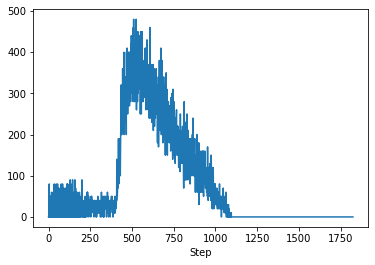

In [238]:
TRT_PERCEPTION=0 #1=인식 악화, 0=없음
TRT_FORCE=0 #1=행위 제제, 0=없음
TRT_TAX=0 #1=게임세 도입
m=P2mGame(NUM_PLAYERS,SEARCH_SPACE_X,SEARCH_SPACE_Y)
for i in range(NUM_GAME_TIME):
    m.step(i)
p=m.datacollector.get_agent_vars_dataframe()
p.groupby('Step')['Spending'].mean().plot()

<AxesSubplot:xlabel='Step'>

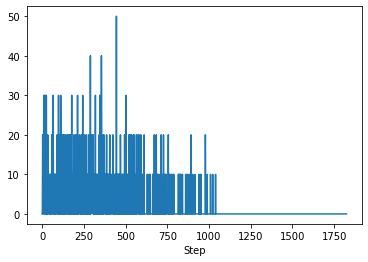

In [239]:
TRT_PERCEPTION=1 #1=인식 악화, 0=없음
TRT_FORCE=0 #1=행위 제제, 0=없음
TRT_TAX=0 #1=게임세 도입
m=P2mGame(NUM_PLAYERS,SEARCH_SPACE_X,SEARCH_SPACE_Y)
for i in range(NUM_GAME_TIME):
    m.step(i)
p=m.datacollector.get_agent_vars_dataframe()
p.groupby('Step')['Spending'].mean().plot()

<AxesSubplot:xlabel='Step'>

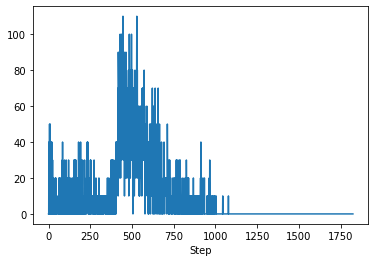

In [240]:
TRT_PERCEPTION=0 #1=인식 악화, 0=없음
TRT_FORCE=1 #1=행위 제제, 0=없음
TRT_TAX=0 #1=게임세 도입
m=P2mGame(NUM_PLAYERS,SEARCH_SPACE_X,SEARCH_SPACE_Y)
for i in range(NUM_GAME_TIME):
    m.step(i)
p=m.datacollector.get_agent_vars_dataframe()
p.groupby('Step')['Spending'].mean().plot()

<AxesSubplot:xlabel='Step'>

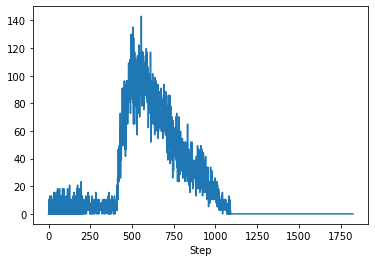

In [241]:
TRT_PERCEPTION=0 #1=인식 악화, 0=없음
TRT_FORCE=0 #1=행위 제제, 0=없음
TRT_TAX=1 #1=게임세 도입
m=P2mGame(NUM_PLAYERS,SEARCH_SPACE_X,SEARCH_SPACE_Y)
for i in range(NUM_GAME_TIME):
    m.step(i)
p=m.datacollector.get_agent_vars_dataframe()
p.groupby('Step')['Spending'].mean().plot()